# Single Cell Analysis


```{hint}
By the end of this notebook, you will be able to:

- Load neuronal reconstructions from multiple sources (local files and demo datasets)
- Visualize neuronal morphology using PySNT's display function
- Extract basic quantitative measurements from neuronal trees using TreeStatistics and its variants
- Generate histograms of morphological features
- Apply statistical fitting to morphological distributions
- Transform neuronal reconstructions using geometric operations and modifications
- Work with SWC-type labels to identify and isolate different cellular compartments

**Estimated Time**: 20 minutes

```

```{note}
Make sure to read this resources before running this notebook:
- [Install](install.md) - Installation instructions
- [Quickstart](quickstart.md) - Get started quickly
- [Overview](overview.md) - Tour of pysnt's architecture
```

In [57]:
# Set logging level to 'Error' to reduce console output (see Overview for details)
import pysnt
pysnt.set_option('java.logging.level', 'Error')

## Loading a Tree

As mentioned in the [Quickstart](../quickstart.md) guide, in SNT a neuronal reconstruction is a `Tree` object.

There are multiple ways to load a tree:
- From a local file
- From a remote database: Using loaders for major online databases: FlyCircuit, InsectBrain, NeuroMorpho, MouseLight 
- From a demo dataset

As always, we start by initializing PySNT:

In [58]:
import pysnt
pysnt.initialize() # initialize with default options

To load a local file we can use:

In [59]:
## Loading from local file
from pysnt import Tree
try:
    tree = Tree('/path/to/a/swc/file.swc')
    tree = Tree('/path/to/a/swc/file.swc', "axon") # will only load axon-tagged nodes
except FileNotFoundError as e1: # Handle Python-exceptions first
    print(f"File does not exist: {e}")
except Exception as e:  # Catch SNT exceptions
    print(f"Unexpected error: {e}")

Unexpected error: java.lang.IllegalArgumentException: File is not available: /path/to/a/swc/file.swc


(which of course will fail, since these files don't exist). 

We wil access reconstruction files from remote databases in subsequent tutorials. 
For now, let's use some demo datasets. We'll use SNTService: SNT's SciJava service that provides convenience access to common operations as well as the running SNT instance: 

In [60]:
from pysnt import SNTService
snt_service = SNTService()
tree = snt_service.demoTree('pyramidal')  # or 'OP1' (DIADEM dataset), or 'DG' (Dentate gyrus granule cell), or 'fractal' for an L-system toy neuron
print(f"Demo tree loaded: {tree.getLabel()}")

Demo tree loaded: AA0001


Let's display it!  We could used one of SNT's advanced viewers like [Reconstruction Viwer]() or [Reconstruction Plotter](), but for now let's simply show the Tree's skeleton. We can use `pysnt.display()`: it is a conveninent function that allows us to automagically display all sorts of objects: from text, to tables, to -- as we'll see in subsequente tutorials -- 3D scenes:

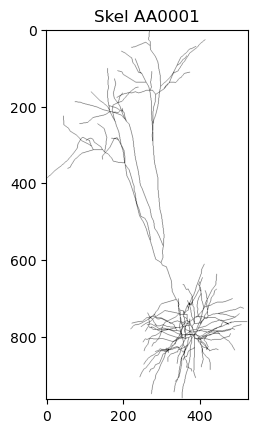

<java object 'ij.ImagePlus'>

In [61]:
pysnt.display(tree)

## Measuring a Tree

Most simply, a Tree can be measured using `TreeStatistics`. Further specialized measurements are retrieved using other classes in [pysnt.analysis](../api_auto/pysnt.analysis.rst). We will discuss those in subsequent tutorials. Here we'll focus on `TreeStatistics`. We construct an instance like so:

In [62]:
from pysnt.analysis import TreeStatistics
t_stats = TreeStatistics(tree)

TreeStatistics provides a variety of single value measurements as well as distribution statistics. Single value metrics:

In [63]:
cable = t_stats.getCableLength()
print("The cable length is %d micrometers" % cable)
n_bps = len(t_stats.getBranchPoints())
print(f"The no. of branch points is: {n_bps}")

The cable length is 13718 micrometers
The no. of branch points is: 82


To see the full list of [supported metrics](https://imagej.net/plugins/snt/metrics), we can use `getMetrics(choice)`, where 'choice' is either 'safe' (metrics that do not require the Tree to validate as an acyclic rooted graph), 'common' (most frequently used), 'quick' (used by SNT's _Quick Measure..._ command), or 'all':

In [64]:
print("The following metrics are available:")
metrics = t_stats.getMetrics('all')
for i in range(0, len(metrics), 2):
    left = f"{i+1:3d}. {metrics[i]}" if i < len(metrics) else ""
    right = f"{i+2:3d}. {metrics[i+1]}" if i+1 < len(metrics) else ""
    print(f'{left:<60}{right}')

The following metrics are available:
  1. Longest shortest path: Extension angle                   2. Longest shortest path: Extension angle XY
  3. Longest shortest path: Extension angle XZ                4. Longest shortest path: Extension angle ZY
  5. Branch contraction                                       6. Branch fractal dimension
  7. Branch length                                            8. Branch mean radius
  9. Branch surface area                                     10. Branch volume
 11. Complexity index: ACI                                   12. Complexity index: DCI
 13. Convex hull: Boundary size                              14. Convex hull: Boxivity
 15. Convex hull: Centroid-root distance                     16. Convex hull: Elongation
 17. Convex hull: Roundness                                  18. Convex hull: Size
 19. Convex hull: Compactness                                20. Convex hull: Eccentricity
 21. Depth                                                 

These metrics can be used to retrieve computations, distributions, etc.

In [65]:
metric = "Internode distance" #fuzzy matching is supported so we can abbreviate distance
summary_stats = t_stats.getSummaryStats(metric)
print("The average inter-node distance is %d µm" % summary_stats.getMean())
print("The standard deviation is %d µm" % summary_stats.getStandardDeviation())

The average inter-node distance is 14 µm
The standard deviation is 6 µm


A neat feature of SNT, is that it is super convenient to inspect quantitative data. E.g., one can plot histograms directly:

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(14.3722, 6.6011)] = -2862.7968
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.69 x Gaussian Distribution(13.5866, 5.9980) + 0.31 x Gaussian Distribution(16.1047, 7.4705)] = -2851.4582
...

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'chart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

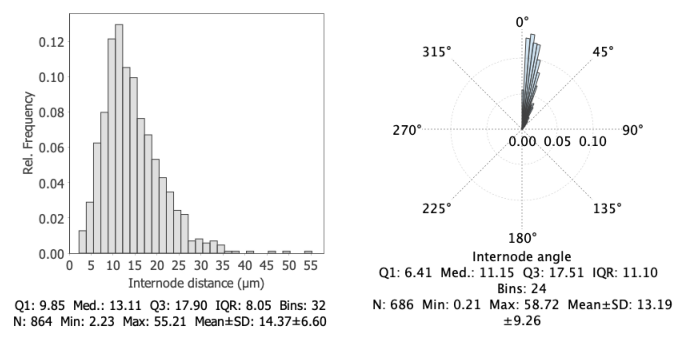

In [66]:
hist1 = t_stats.getHistogram("Internode distance")
hist2 = t_stats.getPolarHistogram("Internode angle")
pysnt.display([hist1, hist2])

Did you notice _GaussianMixture_ debug message in the background? It reflects background computations on the distribution. While SNT is not a statistical package, it does offer entry points for detailed data inspection. E.g., one can fit the histogram distribution to a Gaussian/ Gaussian mixture model directly:

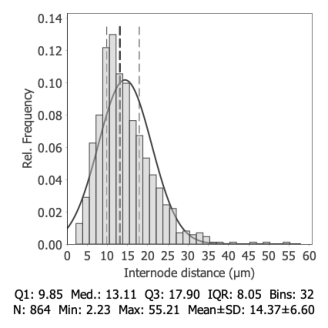

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'png',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Hist. AA0001',
  'containsValidData': True,
  'isLegendVisible': False},
 'error': None}

In [67]:
hist1.setGaussianFitVisible(True) # or hist1.setGMMFitVisible(False) for Gaussian mixture model
hist1.setQuartilesVisible(True) # Display 1st quartile, Median, and 3rd quartile
pysnt.display(hist1)

## Cellular Compartments

If the reconstruction nodes are tagged with SWC-type flags, it is possible to retrieve the cellular compartments (axon, basal dendrites, etc).

Found 3 SWC type labels: [(basal) dendrite, apical dendrite, soma]


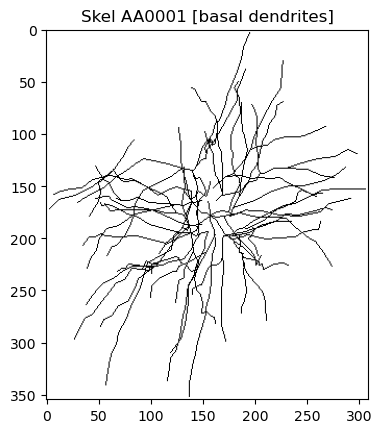

<java object 'ij.ImagePlus'>

In [68]:
# Find out how many compartments exist
types = tree.getSWCTypeNames(True) # include soma?
print(f"Found {len(types)} SWC type labels: {types}")

basal_tree = tree.subTree('basal dendrites')
pysnt.display(basal_tree)


## Transforming Trees

You should be able to use auto-completion on your IDE to explore some of the transformation options available. Transformations occur in place, so we'll work on a copy of the initial tree. Here are some examples.

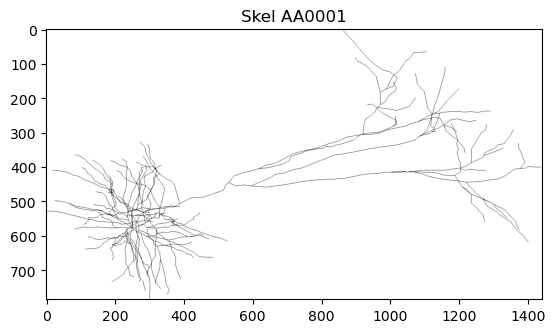

<java object 'ij.ImagePlus'>

In [69]:
tree_transformed = tree.clone() # Duplicate Tree
tree_transformed.rotate(Tree.Z_AXIS, 90) # Rotate around X axis by 90 degrees
tree_transformed.translate(100, 100, 100) # Translate by 100, 100, 100 µm in X,Y,X
tree_transformed.scale(1.5, 1.5, 3.0) # Scale by 1.50 in XY; 3.0 in Z
pysnt.display(tree_transformed)

There re also `transform()` and `transformedCopy()` methods that allow for standardized transformations using space-separated flags: 

Projection flags:
- `zy`: ZY projection
- `xz`: XZ projection

Translation flags:
- `zero-origin`: Tree is translated so that its root has (0,0,0) coordinates

Rotation flags:
- `upright-geodesic`: Tree is rotated to vertically align its graph geodesic
- `upright-tips`:  Tree is rotated to vertically align its [root, tips centroid] vector
- `r#`: With # specifying a positive integer (e.g., r90): Tree is rotated by the specified angle (in degrees)

Example:

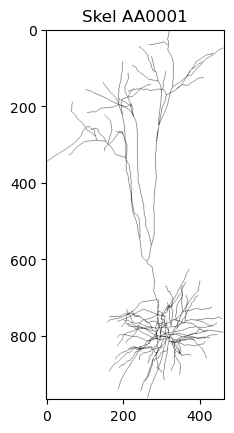

<java object 'ij.ImagePlus'>

In [70]:
tree_transformed = tree
tree_transformed = tree.transformedCopy("upright-geodesic") # Project into xz plane + rotate vertically until the vector [root, tips centroid] is vertical
pysnt.display(tree_transformed)


## Measuring a Group of Trees

Multiple trees are analyzed using `MultiTreeStatistics`, a TreeStatistics variant that analyses trees belonging to a common group. Its usage is rather similar to TreeStatistics. 

We start by importing a group of Trees. As usual we could use local files, e.g., using:

- `Tree.listFromDir('/path/to/a/directory/')` to load all reconstruction files in the directory
- `Tree.listFromDir('/path/to/a/directory/', 'pattern')` to load all reconstruction files in the directory with `pattern` in their filename
- `Tree.listFromDir('/path/to/a/directory/', 'pattern', 'swc_type_label')` to load all reconstruction files in the directory with `pattern` in their filename,  with `swc_type_label` identifiying the compartments to be imported 'soma', 'axon', 'dendrite', 'all', etc.


As before, we'll use a small demo dataset for now, from which we can instantiate a `MultiTreeStatistics` instance:

In [71]:
from pysnt.analysis import MultiTreeStatistics
trees = snt_service.demoTrees() # dendrites from 4 pyramidal cells from the MouseLight database
m_stats = MultiTreeStatistics(trees)
m_stats.setLabel("multiple trees analysis") # Optional: we can set a unifying label to be used in reports, etc.

Sussequent analysis work the same as with `TreeStatistics`:

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(4893.6491, 227.9298)] = -30816.9576
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.42 x Gaussian Distribution(4811.8170, 236.9718) + 0.58 x Gaussian Distribution(4952.9253, 201.3027)] = -30775.8996
...


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'chart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

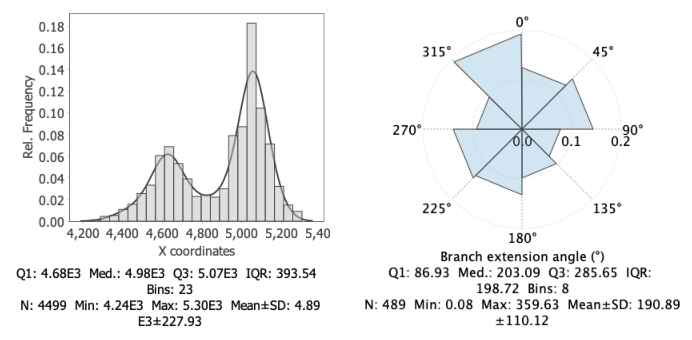

In [72]:
hist1 = m_stats.getHistogram("x coordinates")
hist1.setGMMFitVisible(True)
hist2 = m_stats.getPolarHistogram("branch extension angle")
pysnt.display([hist1, hist2])

To display the group, we can use [Reconstruction Plotter](https://imagej.net/plugins/snt/manual#reconstruction-plotter) (i.e., `Viewer2D`) (we will use 3D viewers in the subsequent tutorials, but for now we'll use the 2D viewer because it is quite simple): 

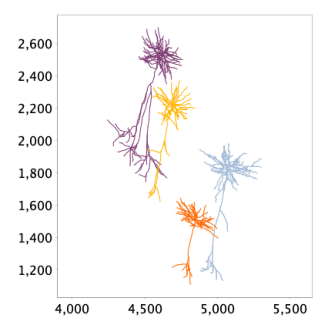

<java object 'sc.fiji.snt.analysis.SNTChart'>

In [73]:
from pysnt.viewer import Viewer2D
viewer = Viewer2D()
viewer.add(trees)
pysnt.display(viewer)

Using what we learned so far, we can display the cells in a more concise way:

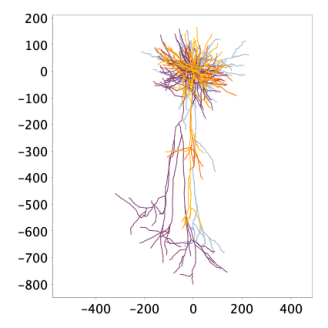

<java object 'sc.fiji.snt.analysis.SNTChart'>

In [74]:
trees_transformed = Tree.transform(trees, "zero-origin upright-geodesic", False) # Move all roots to (0,0,0) coordinate, rotate the cells so their main axis is vertical
viewer = Viewer2D()
viewer.add(trees_transformed)
pysnt.display(viewer)

## Measuring Groups of Trees

Instead of [MultipleTreeStatistics](#measuring-a-group-of-trees), we now use `GroupedTreeStatistics`: The approach is similar to what we've been doing so far, with a minor difference: We will firts initialize the class, then we'll add our cell groups.

To define the cell groups, we'll just split the group cells we've been studying evenly into two sub-groups:



In [75]:
from pysnt.analysis import GroupedTreeStatistics
g_stats = GroupedTreeStatistics()

trees = snt_service.demoTrees() # retrieve demo trees
mid = len(trees) // 2 # group mid point
g_stats.addGroup(trees[:mid], "group 1") # assign first half to group 1
g_stats.addGroup(trees[mid:], "group 2") # assign second half to group 2

def get_histogram(metric):
    hist = g_stats.getHistogram(metric)
    hist.setGaussianFitVisible(True) 
    hist.setQuartilesVisible(True)
    return hist

hist1 = get_histogram("x coordinates")
hist2 = get_histogram("internode angle")

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(4602.7220, 101.9468)] = -8981.2370
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.43 x Gaussian Distribution(4574.4973, 107.9735) + 0.57 x Gaussian Distribution(4623.9380, 91.5477)] = -8972.1973
...


Because we are handling with group statistics, there are new functions to compare groups, including T-testing, and ANOVA-testing. There are also some new plotting options:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x700 with 4 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'chart_count': 4,
  'displayed_count': 4,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

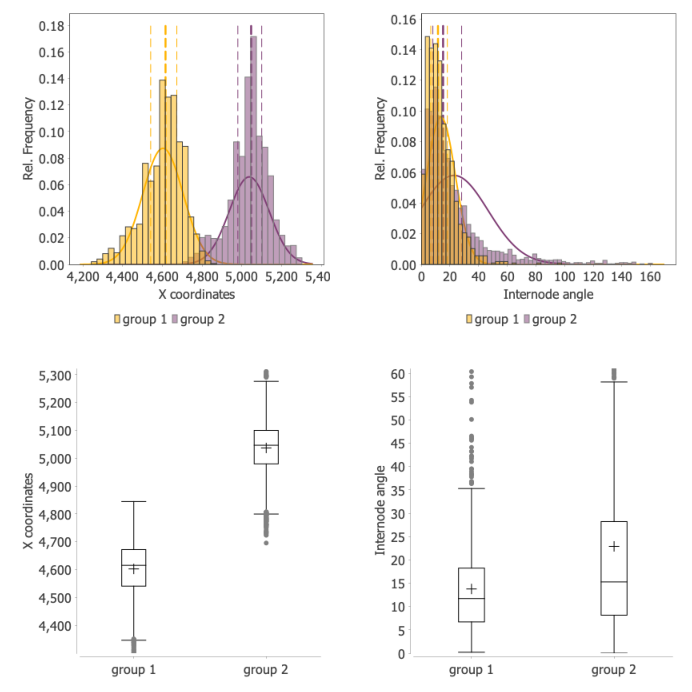

In [76]:
plot1 = g_stats.getBoxPlot("x coordinates")
plot2 = g_stats.getBoxPlot("internode angle")
pysnt.display([hist1, hist2, plot1, plot2])

Internally, each grouped  is assigned by a `MultiTreeStatistics` instance, so we can use the same methods as before, and study each [individual group](#measuring-a-group-of-trees):

In [77]:

for group in g_stats.getGroups():
    m_stats = g_stats.getGroupStats(group) # Retrive the MultiTreeStatistics instance assigned to group
    print(f'Total no. of branch points in {group}: {len(m_stats.getBranches())}')

Total no. of branch points in group 1: 258
Total no. of branch points in group 2: 231


Actually, we can retrieve metrics in bulk like one would do from SNT's [Measurements prompt](https://imagej.net/plugins/snt/analysis#measurements). We can exploit the fact that (Multi)TreeStatistics keeps an internal table of measurements. Thus, the strategy is as follows:

1. Define a master table to hold the data
2. Define a list of metrics
3. For each group, dump measurements into the master table

Let's implement it:

Column 'SWC Type(s)' is all NaN, skipping normalization
Column 'No. of branch points [N]' has no variation (min=max=2), setting to 0.5
Column 'No. of fitted paths [MIN]' has no variation (min=max=0.0), setting to 0.5
...


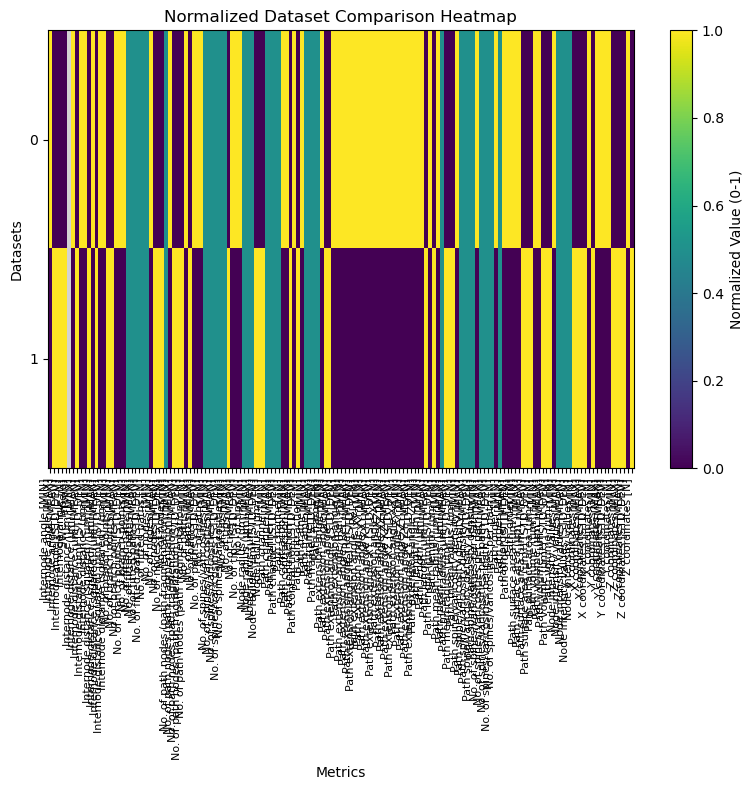

{'type': xarray.core.dataset.Dataset,
 'data': <xarray.Dataset> Size: 2kB
 Dimensions:                                           (index: 2)
 Coordinates:
   * index                                             (index) int64 16B 0 1
 Data variables: (6/151)
     Internode angle [MIN]                             (index) float64 16B 0.2...
     Internode angle [MAX]                             (index) float64 16B 97....
     Internode angle [MEAN]                            (index) float64 16B 13....
     Internode angle [STD_DEV]                         (index) float64 16B 10....
     Internode angle [N]                               (index) int64 16B 1071 ...
     SWC Type(s)                                       (index) object 16B  
     ...                                                ...
 'metadata': {'source_type': 'SNTTable',
  'row_count': 2,
  'column_count': 151,
  'column_names': ['Internode angle [MIN]',
   'Internode angle [MAX]',
   'Internode angle [MEAN]',
   'Internode a

In [82]:
from pysnt.analysis import SNTTable
master_table = SNTTable()

for group in g_stats.getGroups():
    m_stats = g_stats.getGroupStats(group)
    m_stats.setTable(master_table)
    metrics = m_stats.getMetrics('safe')
    m_stats.measure(group, metrics, False) # group description, list of metrics, whether measurements should consider SWC compartment (axon/dendrites)

pysnt.set_option('display.table_mode', 'heatmap_norm')
pysnt.display(master_table)

```{tip}
For interactive data exploration (sorting, filtering, plotting), use:

:::{code-block} python
pysnt.set_option('display.table_mode', 'pandasgui')
pysnt.display(master_table)
:::

For converting the data into a Dataset shareable with numpy, seaborn, pandas, etc., use:

:::{code-block} python
dataset = pysnt.to_python(master_table)
:::
```

To display the groups, we can keep use the same strategy as before:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'Viewer2D_List',
  'viewer2d_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

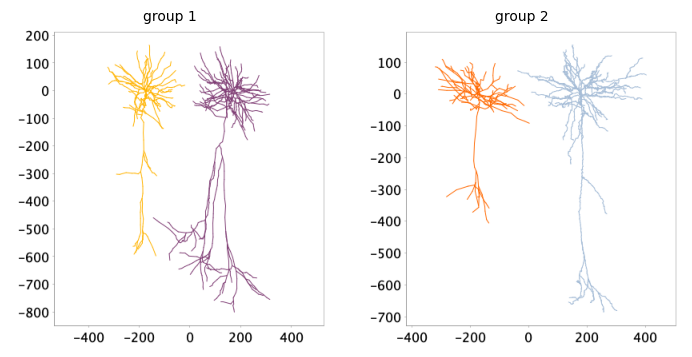

In [79]:
viewers = [] # visualization result: 1 viewer per group

for group in g_stats.getGroups():

    # Retrive the trees in the group
    group_stats = g_stats.getGroupStats(group)
    group_trees = group_stats.getGroup() 

    # Define a viewer for the group
    viewer = Viewer2D()
    
    # Normalize absolute coordinates and rotate cells so their main axis is vertical
    group_trees_transformed = Tree.transform(group_trees, "zero-origin upright-geodesic", False)
    
    # Assign the group color and offset each tree by 350µm left/right
    # for better visualization
    n_trees = len(group_trees_transformed)
    for i, transformed_tree in enumerate(group_trees_transformed):
        # Calculate offset: negative for first half, positive for second half
        offset = (i - (n_trees - 1) / 2) * 350
        transformed_tree.translate(offset, 0, 0)
    
    # Add transformed trees to viewer and store result
    viewer.add(group_trees_transformed)
    viewer.setTitle(group)
    viewers.append(viewer)

pysnt.display(viewers, show_panel_titles=True) 

## Summary and Next Steps

That concludes this tutorial. Have a look at remaining [tutorials](index.md) for further examples.